In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:

def create_model():
    model = None
    model = NeuralNetwork(
        in_features=TS_IN_FEATURES, 
        units=128,
        out_features=1, 
        categorical_dim=CAT_FEATURES,
        no_embedding=NO_EMBEDDING, 
        emb_dim=EMBEDDING_DIM,
        n_blocks=4,
        n_stacks=2,
        dropout=0.3,
        pooling_sizes=3
    )

    print(model)
    return model

# Loop throug each stock
Create Trainer only once

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=128, bias=True)
  (embedding_output): Linear(in_features=128, out_features=1, bias=True)
  (cont_input): Linear(in_features=2, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
  (stacks): ModuleList(
    (0): NeuralStack(
      (blocks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=132, out_features=132, bias=True)
          (layer2): Linear(in_features=132, out_features=132, bias=True)
          (layer3): Linear(in_features=132, out_features=132, bias=True)
          (layer4): Linear(in_features=132, out_features=132, bias=True)
          (fwr_layer): Linear(in_features=132, out_features=132, bias=True)
          (output): Linear(in_features=132, out_features=132, bias=Tru

C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\nn\functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: <<< 0 >>>

                    Average train loss: 2.2201627492904662e-05 | 
                    Train-Mae: 0.1311672329902649 |

                    Average val loss: 0.01518506370484829|
                    Val-Mae: 0.12271029502153397
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 4.8577762208879e-06 | 
                    Train-Mae: 0.0626811608672142 |

                    Average val loss: 0.004052549134939909|
                    Val-Mae: 0.0626579001545906
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 2.1399625111371278e-06 | 
                    Train-Mae: 0.04519294574856758 |

                    Average val loss: 0.0019056908786296844|
                    Val-Mae: 0.042200274765491486
                    
.................... End of epoch 20 ....................
Epoch: <<< 30 >>>

       

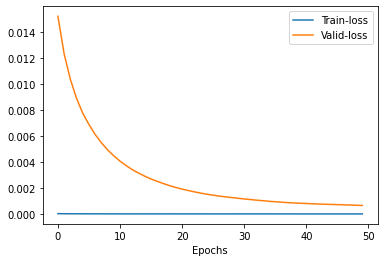

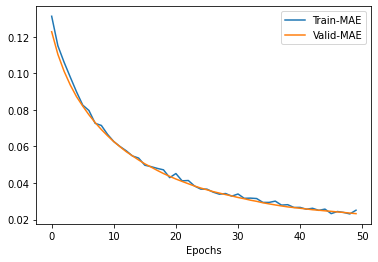

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 7.75856024120003e-07 | 
                    Train-Mae: 0.026239704340696335 |

                    Average val loss: 0.0008383166859857738|
                    Val-Mae: 0.024124586954712868
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 7.715563988313079e-07 | 
                    Train-Mae: 0.022935541346669197 |

                    Average val loss: 0.000724469602573663|
                    Val-Mae: 0.0220005102455616
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 7.588674779981375e-07 | 
                    Train-Mae: 0.022435205057263374 |

                    Average val loss: 0.0006535672582685947|
                    Val-Mae: 0.020571988075971603
                    
.................... End of epoch 20 ....................
Epoch: <<< 30 >>>



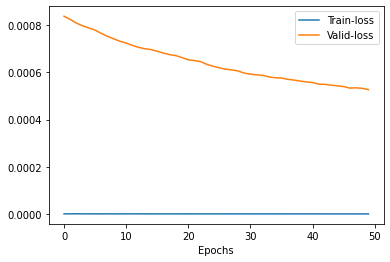

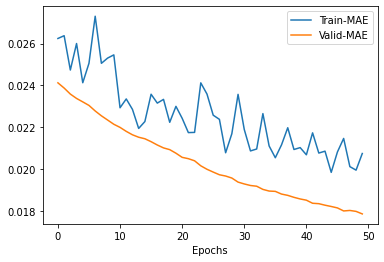

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 6.169450934976339e-07 | 
                    Train-Mae: 0.01797177828848362 |

                    Average val loss: 0.00040003887261264026|
                    Val-Mae: 0.01609627716243267
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 5.363287637010217e-07 | 
                    Train-Mae: 0.018225645646452904 |

                    Average val loss: 0.00037464615888893604|
                    Val-Mae: 0.015446716919541359
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 4.792256513610482e-07 | 
                    Train-Mae: 0.017686590552330017 |

                    Average val loss: 0.00034769531339406967|
                    Val-Mae: 0.014758231118321419
                    
.................... End of epoch 20 ....................
Epoch: <<< 30 

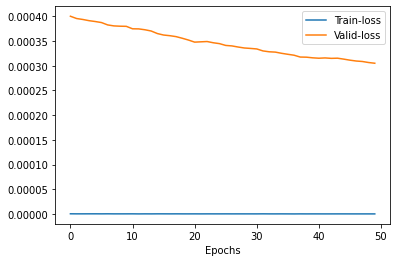

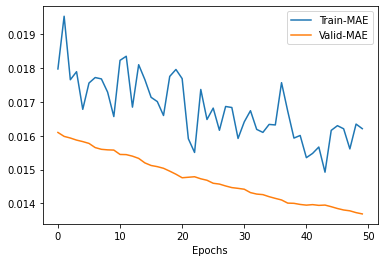

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 3.242925740778446e-07 | 
                    Train-Mae: 0.017659991979599 |

                    Average val loss: 0.0002672882692422718|
                    Val-Mae: 0.012722982093691826
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 2.830565208569169e-07 | 
                    Train-Mae: 0.018170233815908432 |

                    Average val loss: 0.0002514540101401508|
                    Val-Mae: 0.012217107228934765
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 3.22521838825196e-07 | 
                    Train-Mae: 0.01709672622382641 |

                    Average val loss: 0.00023789421538822353|
                    Val-Mae: 0.011787648312747478
                    
.................... End of epoch 20 ....................
Epoch: <<< 30 >>>



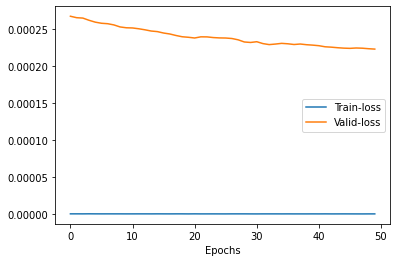

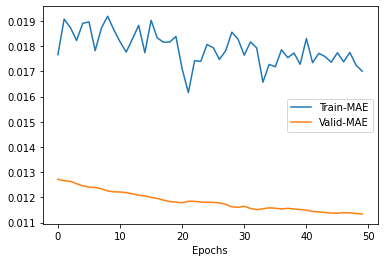

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 3.3712148433551195e-07 | 
                    Train-Mae: 0.015653256326913834 |

                    Average val loss: 0.00023742015764582902|
                    Val-Mae: 0.011382177472114563
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 3.53296403773129e-07 | 
                    Train-Mae: 0.014859486371278763 |

                    Average val loss: 0.0002345243701711297|
                    Val-Mae: 0.01130053959786892
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 3.48924077115953e-07 | 
                    Train-Mae: 0.015704216435551643 |

                    Average val loss: 0.0002289836120326072|
                    Val-Mae: 0.011149803176522255
                    
.................... End of epoch 20 ....................
Epoch: <<< 30 >>

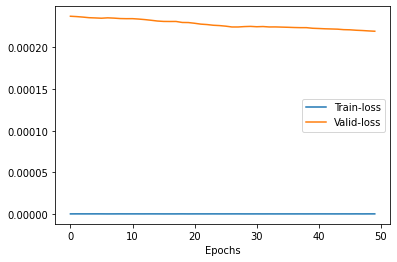

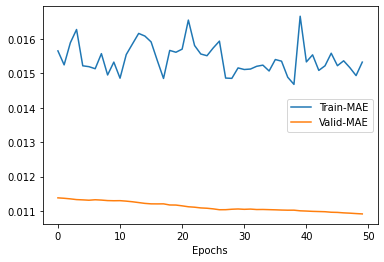

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 1.6103625239338725e-07 | 
                    Train-Mae: 0.013649417087435722 |

                    Average val loss: 0.0001501014339737594|
                    Val-Mae: 0.008191035129129887
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 1.7665160703472794e-07 | 
                    Train-Mae: 0.01224481500685215 |

                    Average val loss: 0.00014800198550801724|
                    Val-Mae: 0.008138293400406837
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 1.657301327213645e-07 | 
                    Train-Mae: 0.012779452838003635 |

                    Average val loss: 0.00014509930042549968|
                    Val-Mae: 0.008046134375035763
                    
.................... End of epoch 20 ....................
Epoch: <<< 3

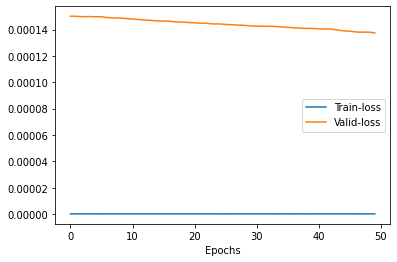

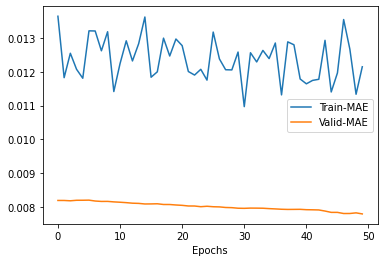

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 7.044867379590869e-07 | 
                    Train-Mae: 0.013415312394499779 |

                    Average val loss: 0.0002044785360340029|
                    Val-Mae: 0.010716263204813004
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 7.28907820302993e-07 | 
                    Train-Mae: 0.013133305124938488 |

                    Average val loss: 0.00019941174832638353|
                    Val-Mae: 0.010533633641898632
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 7.06470338627696e-07 | 
                    Train-Mae: 0.013179016299545765 |

                    Average val loss: 0.0001957567292265594|
                    Val-Mae: 0.010397384874522686
                    
.................... End of epoch 20 ....................
Epoch: <<< 30 >>

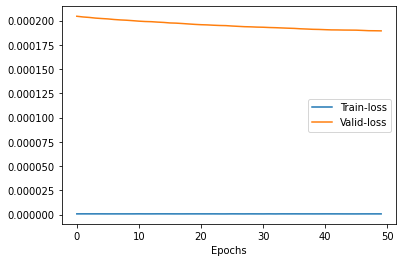

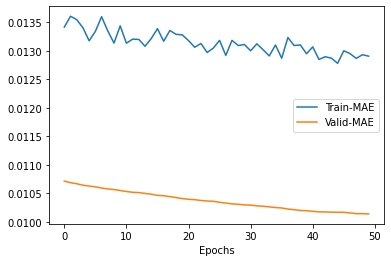

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 6.262199603952468e-07 | 
                    Train-Mae: 0.02451031282544136 |

                    Average val loss: 0.0041753011755645275|
                    Val-Mae: 0.03157724067568779
                    
.................... End of epoch 0 ....................


In [ ]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512
weight_decay = 0.1
EPOCHS = 50
model = create_model()
trainer = Trainer(
    model, 
    optimizer_name='rmsprop', 
    lr=1.3333e-5, 
    weight_decay=weight_decay
)

torch.autograd.set_detect_anomaly(True)

for stock in stocks:
    train_loader, val_dataloader = None, None
    if count > 15:
        break
    print(f'Start training for stock: {stock}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, 
        stock, 
        batch_size=BATCH_SIZE, 
        continous_cols=CONT_COLS
    )
    # if count > 1:
    #     EPOCHS = 5
    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=EPOCHS
    )
    print('#' * 20)
    print()
    count += 1
    
trainer.save_model(model)

    

### 